# Setup

## Imports Necessary Libraries

In [1]:
# ---------- Import Essential Libraries ---------- #

# Machine Learning Essentials #
#import kaggle  uncomment if running locally 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os 
from sklearn.model_selection import train_test_split
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

# import splitfolders 
import pathlib
from pathlib import Path

# Python Utils #
import copy


## If running on local machine, use Kaggle API with the code in the cell below to get the right directory structure

In [2]:
# kaggle.api.authenticate()

# kaggle.api.dataset_download_files('preetviradiya/brian-tumor-dataset', path='data', unzip=True)
# kaggle.api.dataset_metadata('preetviradiya/brian-tumor-dataset', path='.')

## Inputs and Folders

In [3]:
# Globals / Settings
KAGGLE_INPUT   = '/kaggle/input'
DATA_METADATA  = '/kaggle/input/brian-tumor-dataset/metadata.csv'
DATA_DIRECTORY = '/kaggle/input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set'


# Run cell below if working in Kaggle
## Read in data and make a dataframe with the filepaths and labels associated with said file path


In [4]:
# Define the directories and labels for both folders of images 

directories = {
    "Brain Tumor": '/kaggle/input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor',
    "Healthy":  '/kaggle/input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/Healthy'
}

# Create list of filepaths and a list of labels 
filepaths = []
labels = [] 

# Iterate through the directories and collect the file paths and labels 
for label, path in directories.items():
    for name in os.listdir(path):
        filepaths.append(os.path.join(path, name))
        labels.append(label)


# Create a dataframe with the file paths and the labels 

df = pd.DataFrame({"filepaths": filepaths, "labels": labels})




# Run cell below if working locally 
## Note this requires the Kaggle API to get the directory structure required

In [5]:
# # Define the directories and labels for both folders of images 

# directories = {
#   "Brain Tumor":'./data/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor',
#   "Healthy":'./data/Brain Tumor Data Set/Brain Tumor Data Set/Healthy'
# }

# # Check if Files Exist
# print(os.path.exists('./data/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor'))
# print(os.path.exists('./data/Brain Tumor Data Set/Brain Tumor Data Set/Healthy'))

# # Create list of filepaths and a list of labels 
# filepaths = []
# labels = [] 

# # Iterate through the directories and collect the file paths and labels 
# for label, path in directories.items():
#   for name in os.listdir(path):
#     filepaths.append(os.path.join(path, name))
#     labels.append(label)


# # Create a dataframe with the file paths and the labels 

# df = pd.DataFrame({"filepaths": filepaths, "labels": labels})

In [6]:
df.head()

,filepaths,labels
0,/kaggle/input/brian-tumor-dataset/Brain Tumor ...,Brain Tumor
1,/kaggle/input/brian-tumor-dataset/Brain Tumor ...,Brain Tumor
2,/kaggle/input/brian-tumor-dataset/Brain Tumor ...,Brain Tumor
3,/kaggle/input/brian-tumor-dataset/Brain Tumor ...,Brain Tumor
4,/kaggle/input/brian-tumor-dataset/Brain Tumor ...,Brain Tumor


## Split data into training, testing, and validation sets

In [7]:
train_df, test_df = train_test_split(df, test_size=0.25, random_state=42,stratify=df.labels)
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=42,stratify=train_df.labels)
print(f"Training set is of shape {train_df.shape}")
print(f"Testing set is of shape {test_df.shape}")
print(f"Validation set is of shape {val_df.shape}")



Training set is of shape (2932, 2)
Testing set is of shape (1150, 2)
Validation set is of shape (518, 2)


# Preprocess Images 

### Enhance the image 
If time permits, increase contrast using cv2.addWeighted, Sharpen with a kernel using OpenCV's filter2D function, and a couple other operations 

In [8]:
# Add code to enhance the image if it makes the model perform better 


# Data Generators (Batching, Data Augmentation, On-the-fly-processing, and flow control) 

In [9]:
# Use tensorflows ImageDataGenerator to preprocess the images 

# rescale parameter will scale pixel values to the range [0,1] 
image_generator = ImageDataGenerator(
    rescale=1./255 # Normalize image pixel values from [0,255] to [0,1]
)

# Create a data generator for the training set
train = image_generator.flow_from_dataframe(
    dataframe=train_df,         # DataFrame containing file paths and labels for training data
    x_col="filepaths",          # Column in the DataFrame with the file paths to the images
    y_col="labels",             # Column in the DataFrame with the labels for the images
    target_size=(256, 256),     # Resize all images to 256x256 pixels
    color_mode='rgb',           # Load images in RGB format (3 color channels)
    class_mode="categorical",   # Generate one-hot encoded labels for multi-class classification
    batch_size=64,              # Number of images to generate per batch
    shuffle=False               # Do not shuffle the order of images in this generator
)

# Create a data generator for the test set
test = image_generator.flow_from_dataframe(
    dataframe=test_df,          # DataFrame containing file paths and labels for test data
    x_col="filepaths",          # Column in the DataFrame with the file paths to the images
    y_col="labels",             # Column in the DataFrame with the labels for the images
    target_size=(256, 256),     # Resize all images to 256x256 pixels
    color_mode='rgb',           # Load images in RGB format
    class_mode="categorical",   # Generate one-hot encoded labels for evaluation
    batch_size=64,              # Number of images to generate per batch
    shuffle=False               # Do not shuffle the order, as this is for testing
)

# Create a data generator for the validation set
val = image_generator.flow_from_dataframe(
    dataframe=val_df,           # DataFrame containing file paths and labels for validation data
    x_col="filepaths",          # Column in the DataFrame with the file paths to the images
    y_col="labels",             # Column in the DataFrame with the labels for the images
    target_size=(256, 256),     # Resize all images to 256x256 pixels
    color_mode='rgb',           # Load images in RGB format
    class_mode="categorical",   # Generate one-hot encoded labels for validation
    batch_size=64,              # Number of images to generate per batch
    shuffle=False               # Do not shuffle the order, as this is for validation
)


Found 2932 validated image filenames belonging to 2 classes.
Found 1150 validated image filenames belonging to 2 classes.
Found 518 validated image filenames belonging to 2 classes.


# Examples from dataset



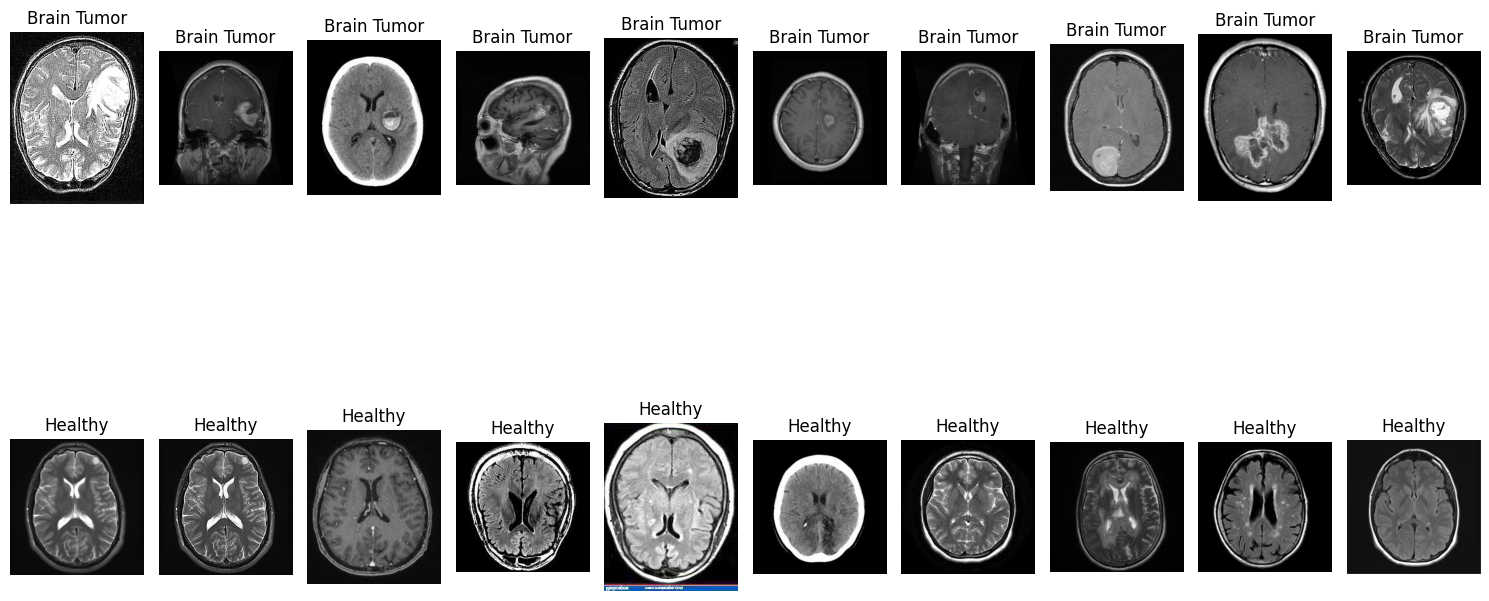

In [10]:
# Arbritrary number of images from each class in the dataset 
images_per_class = 10

# Get class labels
class_labels = train.class_indices.keys()

# Initialize plot 
plt.figure(figsize=(15, 10))

# Plot images for each class
for label_index, label in enumerate(class_labels):
    # Get the filepaths of the current class 
    filepaths = train_df.loc[train_df['labels'] == label, 'filepaths']
    
    # Randomly select images to display
    selected_filepaths = np.random.choice(filepaths, min(images_per_class, len(filepaths)), replace=False)
    
    # Plot the images
    for i, filepath in enumerate(selected_filepaths):
        plt_idx = label_index * images_per_class + i + 1
        plt.subplot(len(class_labels), images_per_class, plt_idx)
        plt.imshow(plt.imread(filepath))
        plt.title(label)
        plt.axis('off')

plt.tight_layout()
plt.show()


# Create CNN and Compile the Model 

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),  # First Conv Layer
    MaxPooling2D((2, 2)),                                               # Max Pooling
    Conv2D(64, (3, 3), activation='relu'),                              # Second Conv Layer
    MaxPooling2D((2, 2)),                                               # Max Pooling
    Conv2D(128, (3, 3), activation='relu'),                             # Third Conv Layer
    MaxPooling2D((2, 2)),                                               # Max Pooling
    Flatten(),                                                          # Flatten the output
    Dense(128, activation='relu'),                                      # Fully Connected Layer
    Dropout(0.5),                                                       # Dropout for regularization
    Dense(len(train.class_indices), activation='softmax')               # Output layer with softmax activation
])

# Compile the model
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',   # Since it's multi-class classification
    metrics=['accuracy']
)

# Summary of the model architecture
model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,839,234 (56.61 MB)

 Trainable params: 14,839,234 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

# Train the Model

In [12]:
# Train the model
history = model.fit(
    train,                           # Training data
    epochs=20,                        # Number of epochs
    validation_data=val,              # Validation data
    steps_per_epoch=train.samples // train.batch_size,    # Steps per epoch
    validation_steps=val.samples // val.batch_size,        # Validation steps
    verbose=1
)

# Save the trained model (optional)
model.save('cnn_model.h5')


Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1732998323.569130      70 service.cc:145] XLA service 0x7ac1380043e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732998323.569184      70 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732998323.569188      70 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 2/45 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.4570 - loss: 2.0198 

I0000 00:00:1732998335.246213      70 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


45/45 ━━━━━━━━━━━━━━━━━━━━ 48s 709ms/step - accuracy: 0.5719 - loss: 1.1121 - val_accuracy: 0.7715 - val_loss: 0.4846
Epoch 2/20
 1/45 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 0.7812 - loss: 0.5117

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7812 - loss: 0.5117 - val_accuracy: 0.6667 - val_loss: 0.8171
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 234ms/step - accuracy: 0.7800 - loss: 0.4773 - val_accuracy: 0.8633 - val_loss: 0.3806
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step - accuracy: 0.8438 - loss: 0.3603 - val_accuracy: 0.6667 - val_loss: 0.5166
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 236ms/step - accuracy: 0.8610 - loss: 0.3185 - val_accuracy: 0.8750 - val_loss: 0.3198
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - accuracy: 0.9219 - loss: 0.2335 - val_accuracy: 1.0000 - val_loss: 0.2695
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 235ms/step - accuracy: 0.9025 - loss: 0.2377 - val_accuracy: 0.9238 - val_loss: 0.2231
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - accuracy: 0.9062 - loss: 0.2075 - val_accuracy: 1.0000 - val_loss: 0.1245
Epoch 9/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 233ms/step - accuracy: 0.9481 - loss: 0.1391 - val_accuracy: 0.9336 - v

In [13]:
loss, accuracy = model.evaluate(test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 690ms/step - accuracy: 0.9710 - loss: 0.1426
Test Loss: 0.1650574803352356
Test Accuracy: 0.969565212726593


## Create plots of training and validation accuracy as a fucntion of the number of Epochs as well as training and validation as a function of the number of epochs

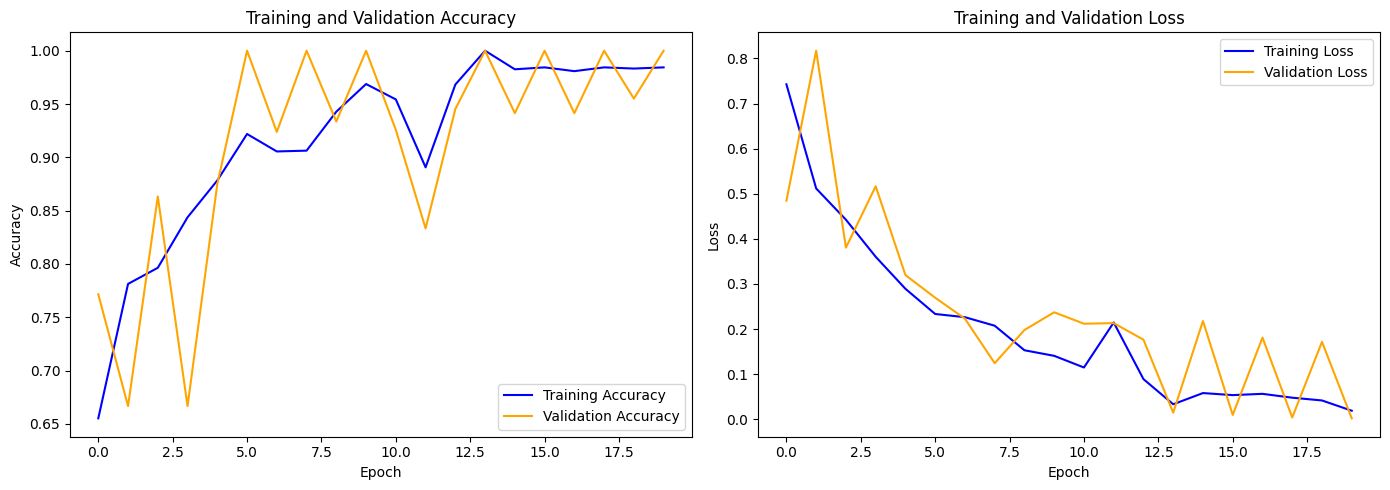

In [14]:
# Retrieve accuracy and loss data from history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a figure with two subplots: one for accuracy and one for loss
plt.figure(figsize=(14, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy', color='blue')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Adjust layout to prevent overlapping
plt.tight_layout()

# Display the plot
plt.show()


# Create Confusion Matrix


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 210ms/step


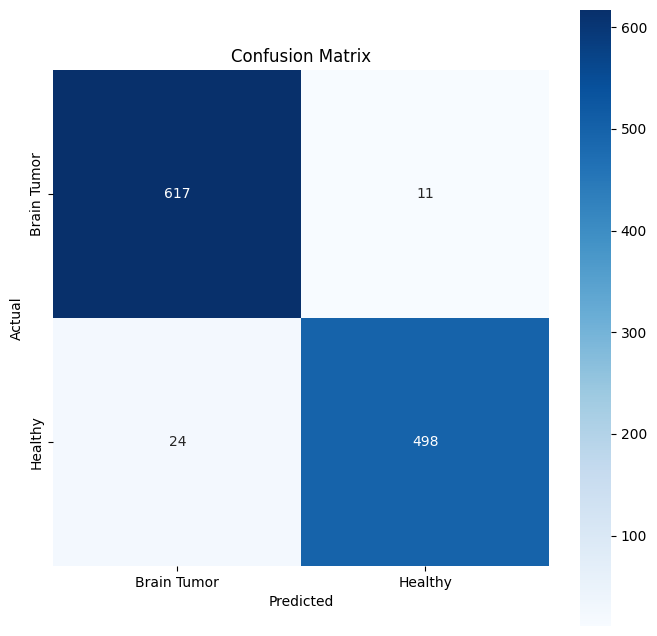

In [15]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Get predictions for the test data
y_pred = model.predict(test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels for the test data
true_classes = test.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, y_pred_classes)

# Plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', square=True, 
            xticklabels=test.class_indices.keys(), yticklabels=test.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## What we know so far: 
The model is working and it is around 95.8% accurate with 15 epochs. 

# TODO Add Grad CAM section